# Save annual IRF calibration data

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import datetime as dt
import glob
import os.path
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scmdata
import seaborn as sns
import statsmodels.api as sm
import tqdm.autonotebook as tqdman
from openscm_units import unit_registry
from patsy import dmatrices

import config

<ipython-input-2-91b018e19e24>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [3]:
ID = config.ID

<IPython.core.display.Javascript object>

In [4]:
STITCHED_NORMALISED_DIR = "./{}-irf-calibration-crunch-stitched-normalised".format(ID)

MAX_WORKERS = 60

<IPython.core.display.Javascript object>

In [5]:
load_dir = STITCHED_NORMALISED_DIR

<IPython.core.display.Javascript object>

In [6]:
crunched_files = [
    f
    for f in glob.glob(os.path.join(load_dir, "**", "*.nc"), recursive=True)
    if "abrupt-4xCO2" in f
]
crunched_files[:2]
display(len(crunched_files))
crunched_files

193

['./20210416-irf-calibration-crunch-stitched-normalised/netcdf-scm_rsut_Amon_EC-Earth3-Veg_abrupt-4xCO2_r1i1p1f1_gr_185001-200012.nc',
 './20210416-irf-calibration-crunch-stitched-normalised/netcdf-scm_rsdt_Amon_BCC-ESM1_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc',
 './20210416-irf-calibration-crunch-stitched-normalised/netcdf-scm_rlut_Amon_AWI-CM-1-1-MR_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc',
 './20210416-irf-calibration-crunch-stitched-normalised/netcdf-scm_rsut_Amon_GISS-E2-2-G_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc',
 './20210416-irf-calibration-crunch-stitched-normalised/netcdf-scm_rsut_Amon_EC-Earth3-AerChem_abrupt-4xCO2_r1i1p1f1_gr_197401-199912.nc',
 './20210416-irf-calibration-crunch-stitched-normalised/netcdf-scm_rsut_Amon_NorCPM1_abrupt-4xCO2_r1i1p1f1_gn_101-15012.nc',
 './20210416-irf-calibration-crunch-stitched-normalised/netcdf-scm_rlut_Amon_MRI-ESM2-0_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc',
 './20210416-irf-calibration-crunch-stitched-normalised/netcdf-scm_rlut

<IPython.core.display.Javascript object>

In [7]:
def load_file(f):
    out = force_first_year(scmdata.ScmRun.from_nc(f), new_first_year_value=1)

    return out


def force_first_year(inp, new_first_year_value=1):
    """
    Force first year of an :obj:`ScmRun` to match a given value
    """
    ts = inp.timeseries()
    first_year = inp["year"].min()
    ts.columns = ts.columns.map(
        lambda x: dt.datetime(
            x.year - first_year + new_first_year_value, x.month, x.day
        )
    )

    out = scmdata.ScmRun(ts)
    out.metadata = inp.metadata

    return out


all_dat = []
with Pool(MAX_WORKERS) as pool:
    all_dat = pool.map(load_file, crunched_files)

all_dat = scmdata.run_append(
    [scmdata.ScmRun(s.timeseries(time_axis="year-month")) for s in tqdman.tqdm(all_dat)]
)
all_dat

/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_varia

/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_varia

/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_varia

  0%|          | 0/193 [00:00<?, ?it/s]

<scmdata.ScmRun (timeseries: 193, timepoints: 12000)>
Time:
	Start: 0001-01-16T05:00:00
	End: 1000-12-16T19:00:00
Meta:
	    activity_id      climate_model grid  member_id mip_era        model  \
	0          CMIP      EC-Earth3-Veg   gr   r1i1p1f1   CMIP6  unspecified   
	1          CMIP           BCC-ESM1   gn   r1i1p1f1   CMIP6  unspecified   
	2          CMIP      AWI-CM-1-1-MR   gn   r1i1p1f1   CMIP6  unspecified   
	3          CMIP        GISS-E2-2-G   gn   r1i1p1f1   CMIP6  unspecified   
	4          CMIP  EC-Earth3-AerChem   gr   r1i1p1f1   CMIP6  unspecified   
	..          ...                ...  ...        ...     ...          ...   
	188        CMIP      EC-Earth3-Veg   gr   r1i1p1f1   CMIP6  unspecified   
	189        CMIP            CanESM5   gn   r1i1p1f1   CMIP6  unspecified   
	190        CMIP        CAMS-CSM1-0   gn   r1i1p1f1   CMIP6  unspecified   
	191        CMIP    HadGEM3-GC31-MM   gn   r1i1p1f3   CMIP6  unspecified   
	192        CMIP       IPSL-CM6A-LR   gr  r1

<IPython.core.display.Javascript object>

In [8]:
def get_gregory_plot_df(inp, tas_unit="K", flux_unit="W / m^2"):
    gregory_plot_df = (
        inp.time_mean("AC")
        .convert_unit(tas_unit, variable="tas")
        .convert_unit(flux_unit, variable="r*")
        .drop_meta("variable_standard_name")
        .timeseries(time_axis="year")
        .reset_index("unit", drop=True)
        .unstack("variable")
        .stack("time")
    )
    gregory_plot_df["rndt"] = (
        gregory_plot_df["rsdt"] - gregory_plot_df["rsut"] - gregory_plot_df["rlut"]
    )

    return gregory_plot_df

<IPython.core.display.Javascript object>

In [9]:
def get_gregory_regression_values(gregory_plot_df, tas_unit, flux_unit):
    y, X = dmatrices("rndt ~ tas", data=gregory_plot_df, return_type="dataframe")
    mod = sm.OLS(y, X)
    res = mod.fit()

    intercept = res.params["Intercept"]
    gradient = res.params["tas"]
    lambda_val = -gradient * unit_registry(f"{flux_unit} / {tas_unit}")
    forcing_4xco2 = intercept * unit_registry(f"{flux_unit}")
    forcing_2xco2 = forcing_4xco2 / 2
    ecs = forcing_2xco2 / lambda_val

    return {
        "lambda": lambda_val,
        "rf_4xco2": forcing_4xco2,
        "rf_2xco2": forcing_2xco2,
        "ecs": ecs,
    }

<IPython.core.display.Javascript object>

In [10]:
def make_gregory_plot(
    gregory_regression_values, gregory_plot_df, tas_unit, flux_unit, ax, style=None
):
    scat_kwgs = dict(
        data=gregory_plot_df,
        y="rndt",
        x="tas",
        ax=ax,
    )
    if style is not None:
        scat_kwgs["style"] = style

    ax = sns.scatterplot(**scat_kwgs)

    ax.set_xlim(xmin=0)

    rf_4xco2 = gregory_regression_values["rf_4xco2"]
    lambda_val = gregory_regression_values["lambda"]
    #     print(ax.get_xlim())

    x_vals = np.array([0, (rf_4xco2 / lambda_val).to(tas_unit).magnitude])
    ax.set_xlim(x_vals)
    print(x_vals)
    ax.plot(
        x_vals,
        (rf_4xco2 - (lambda_val * (x_vals * unit_registry(tas_unit))))
        .to(flux_unit)
        .magnitude,
        label="Gregory regression (\n   ECS: {:.2f} \n   lambda: {:.2f} \n   rf 4xCO2: {:.2f}\n)".format(
            gregory_regression_values["ecs"],
            lambda_val,
            gregory_regression_values["rf_4xco2"],
        ),
        color="grey",
    )
    ax.legend()

    def _get_index_vals(idf, c):
        out = idf.index.get_level_values(c).unique()
        assert len(out) == 1, out

        return out[0]

    ax.set_title(
        "{} {}".format(
            _get_index_vals(gregory_plot_df, "climate_model"),
            _get_index_vals(gregory_plot_df, "member_id"),
        )
    )

    ax.set_xlabel(f"tas ({tas_unit})")
    ax.set_ylabel(f"rndt ({flux_unit})")
    ax.axhline(0, color="gray")

    return ax

<IPython.core.display.Javascript object>

0it [00:00, ?it/s]

{'lambda': 0.7399232625681157 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.884856221356658 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.442428110678329 <Unit('watt / meter ** 2')>,
 'ecs': 4.652412330881984 <Unit('kelvin')>}

[0.         9.30482466]


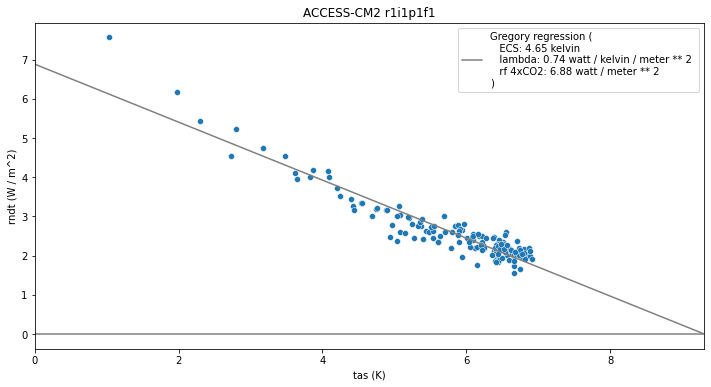

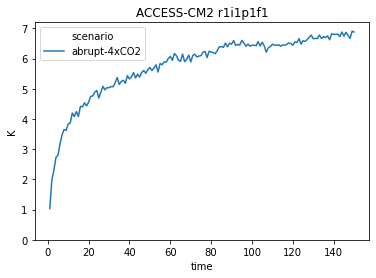

{'lambda': 0.6999582560614045 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 5.516379795030314 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 2.758189897515157 <Unit('watt / meter ** 2')>,
 'ecs': 3.9405062710956757 <Unit('kelvin')>}

[0.         7.88101254]


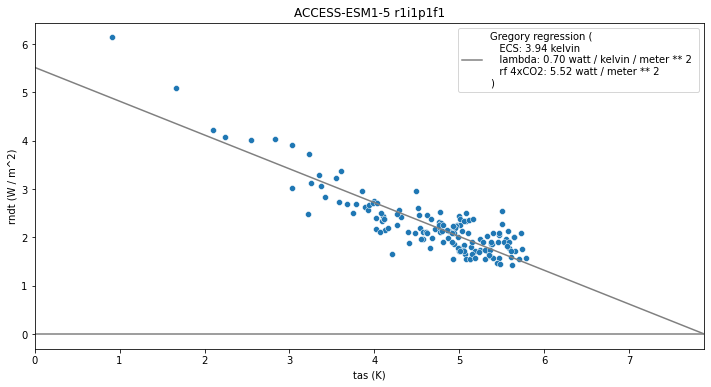

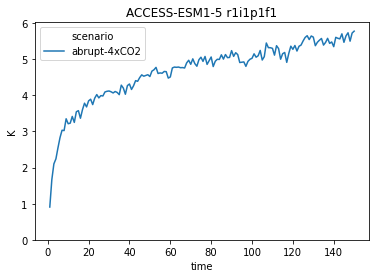

ACCESS-ESM1-5 r2i1p1f1 is missing data for {'rsut', 'rsdt', 'rlut'}


{'lambda': 1.1482735819782628 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.260651347940198 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.630325673970099 <Unit('watt / meter ** 2')>,
 'ecs': 3.161551159015363 <Unit('kelvin')>}

[0.         6.32310232]


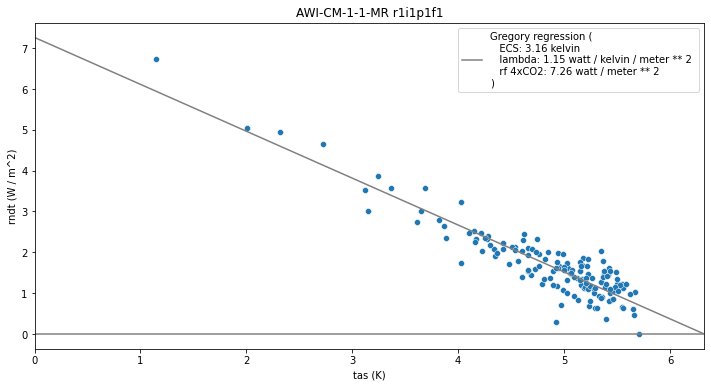

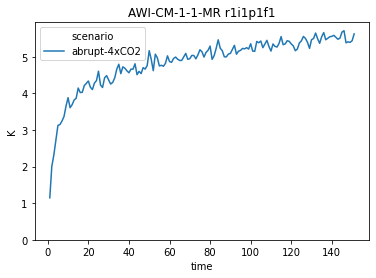

{'lambda': 1.1323244132131758 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.673836235334306 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.336918117667153 <Unit('watt / meter ** 2')>,
 'ecs': 2.9469629716787993 <Unit('kelvin')>}

[0.         5.89392594]


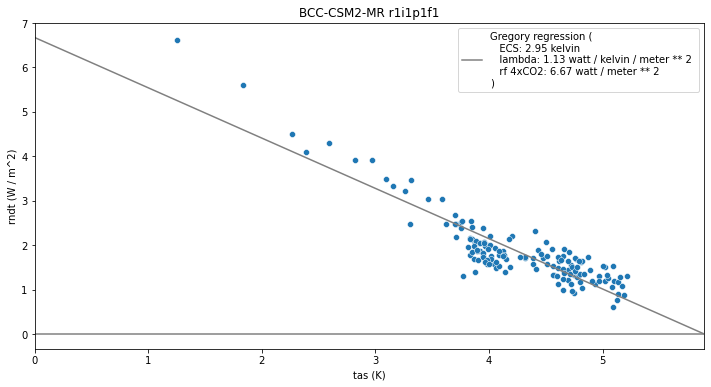

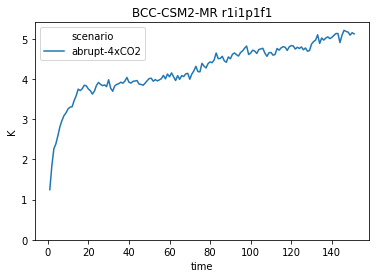

{'lambda': 0.8606914790690684 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 5.728465371191939 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 2.8642326855959697 <Unit('watt / meter ** 2')>,
 'ecs': 3.327827398377348 <Unit('kelvin')>}

[0.        6.6556548]


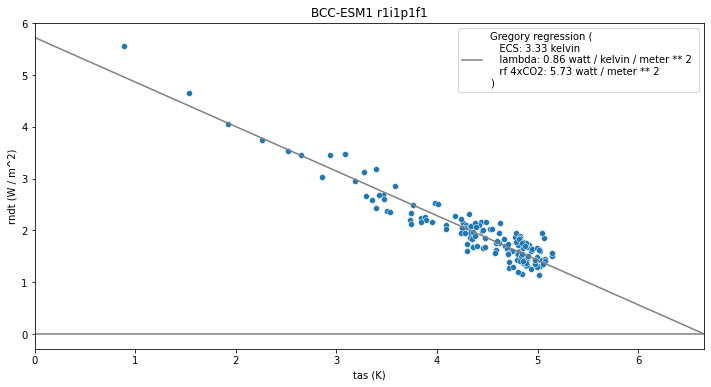

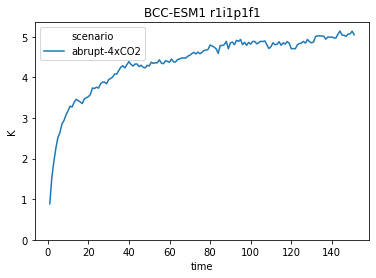

{'lambda': 1.8207510337924078 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 8.341282949435572 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 4.170641474717786 <Unit('watt / meter ** 2')>,
 'ecs': 2.290616013563829 <Unit('kelvin')>}

[0.         4.58123203]


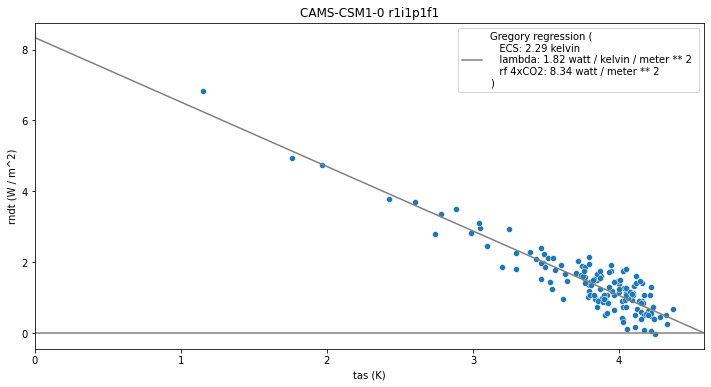

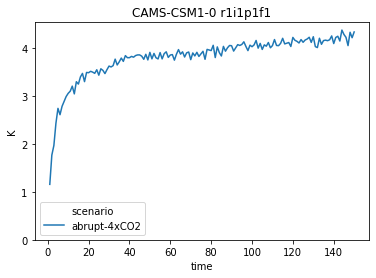

{'lambda': 1.8316010444529212 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 8.39283101108066 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 4.19641550554033 <Unit('watt / meter ** 2')>,
 'ecs': 2.2911187555004657 <Unit('kelvin')>}

[0.         4.58223751]


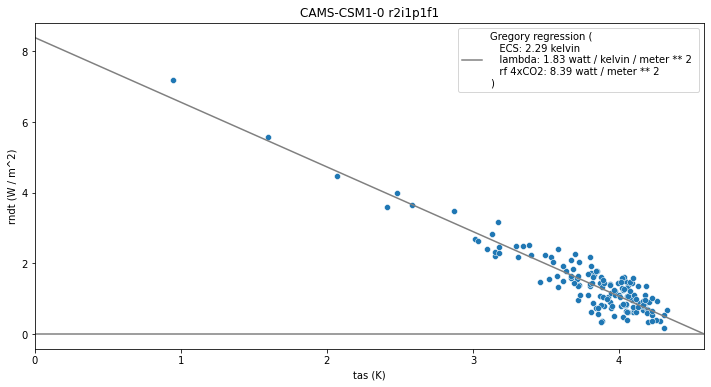

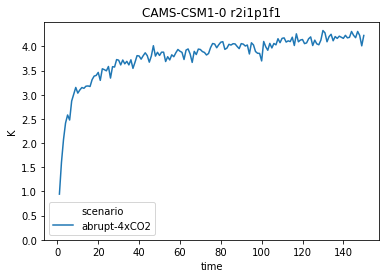

{'lambda': 0.5547921684719986 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 5.7213069406243875 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 2.8606534703121937 <Unit('watt / meter ** 2')>,
 'ecs': 5.156261448662781 <Unit('kelvin')>}

[ 0.        10.3125229]


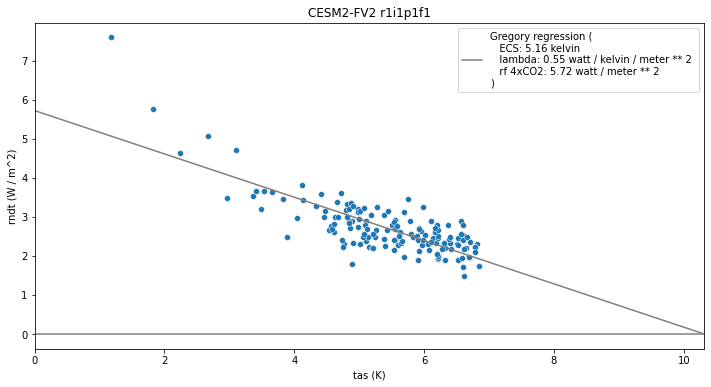

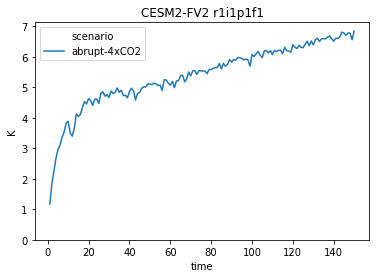

{'lambda': 0.7052265950406745 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.605080902697428 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.302540451348714 <Unit('watt / meter ** 2')>,
 'ecs': 4.682949387576963 <Unit('kelvin')>}

[0.         9.36589878]


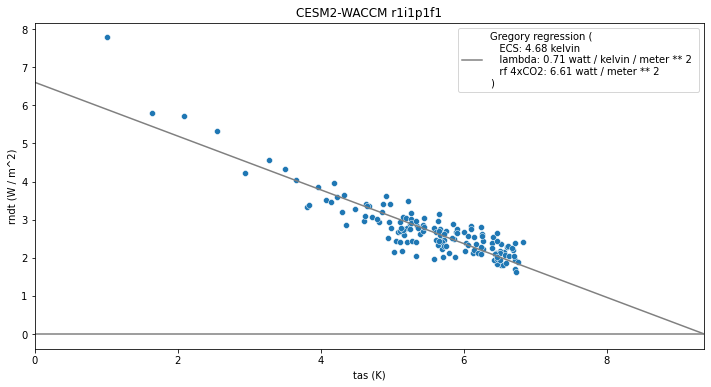

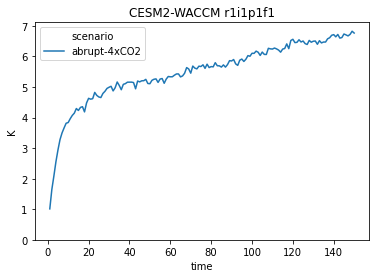

{'lambda': 0.6108743716176457 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 5.843366336539503 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 2.9216831682697517 <Unit('watt / meter ** 2')>,
 'ecs': 4.7827889072067205 <Unit('kelvin')>}

[0.         9.56557781]


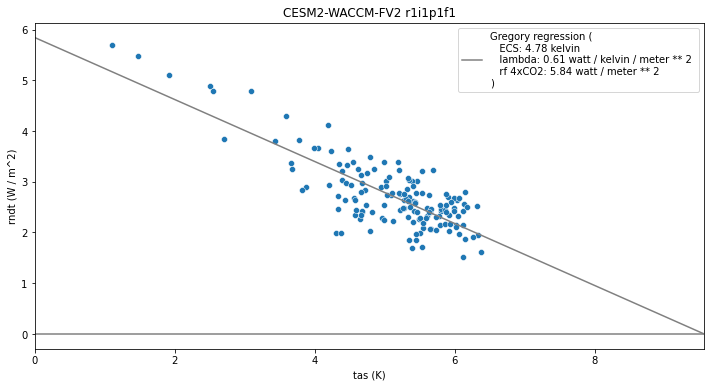

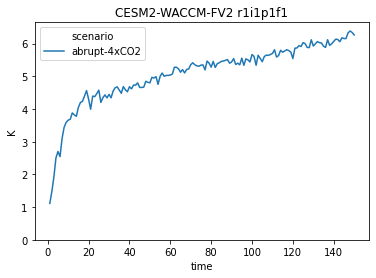

{'lambda': 1.0113159967038952 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.290208920702724 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.645104460351362 <Unit('watt / meter ** 2')>,
 'ecs': 3.6043180096345475 <Unit('kelvin')>}

[0.         7.20863602]


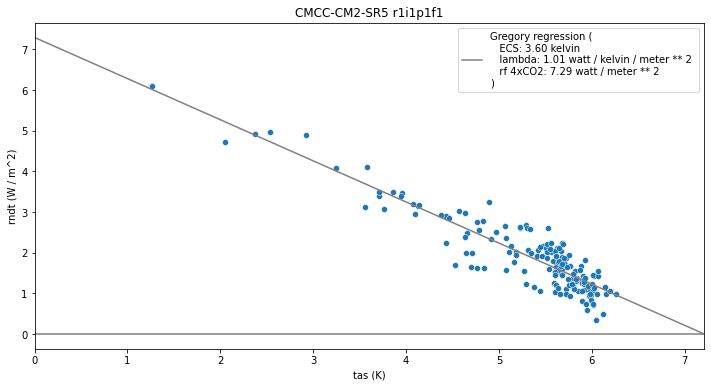

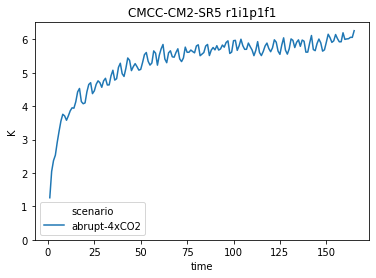

{'lambda': 1.0144121966553052 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.318254689754061 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.6591273448770303 <Unit('watt / meter ** 2')>,
 'ecs': 3.6071405262494025 <Unit('kelvin')>}

[0.         7.21428105]


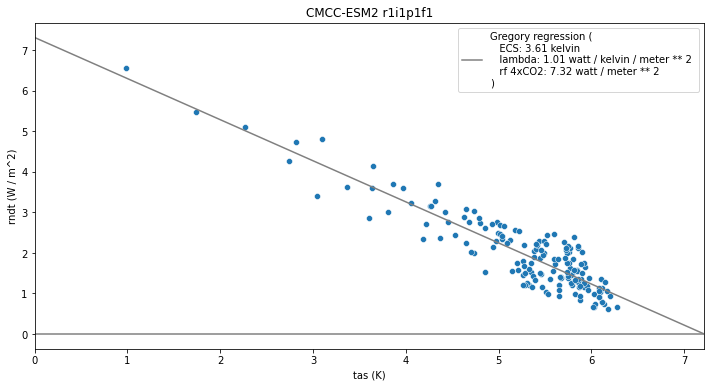

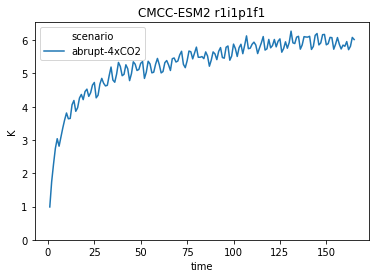

{'lambda': 0.7535334791893257 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.348071902032003 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.6740359510160014 <Unit('watt / meter ** 2')>,
 'ecs': 4.875743483844462 <Unit('kelvin')>}

[0.         9.75148697]


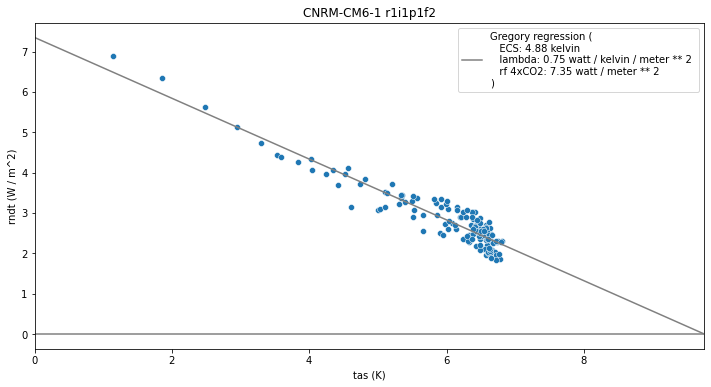

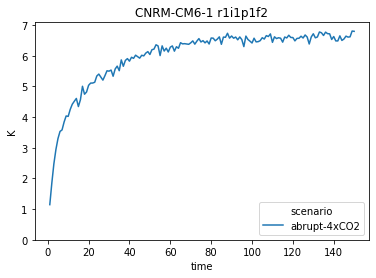

{'lambda': 0.9516950709517338 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 8.15549736999442 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 4.07774868499721 <Unit('watt / meter ** 2')>,
 'ecs': 4.2847218709657655 <Unit('kelvin')>}

[0.         8.56944374]


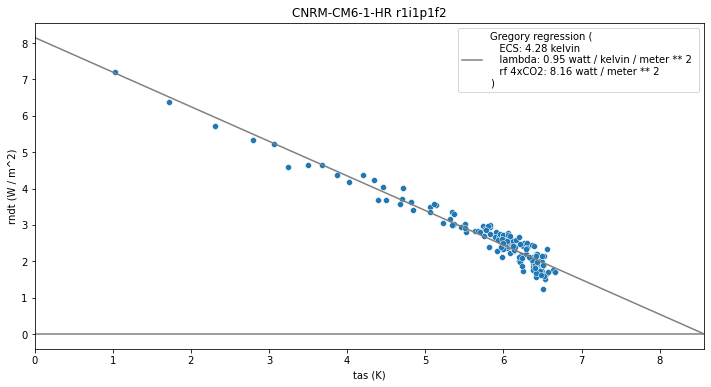

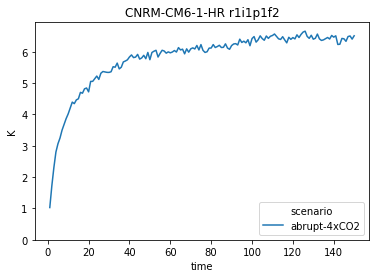

{'lambda': 0.5955535198486216 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 5.8001904038871706 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 2.9000952019435853 <Unit('watt / meter ** 2')>,
 'ecs': 4.869579484108724 <Unit('kelvin')>}

[0.         9.73915897]


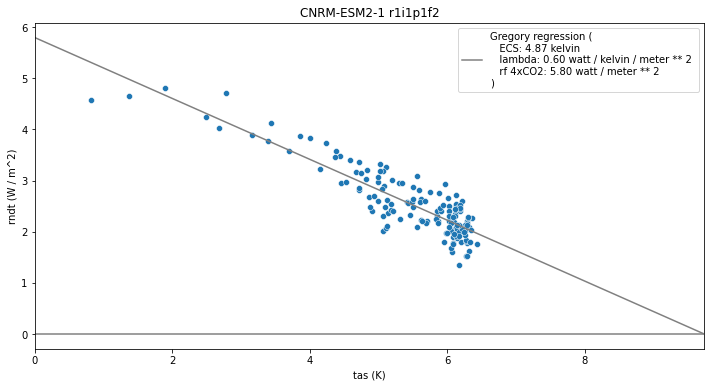

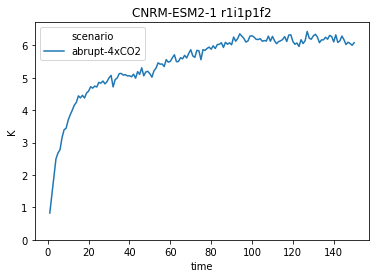

{'lambda': 0.6018572078407655 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.984841309742804 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.492420654871402 <Unit('watt / meter ** 2')>,
 'ecs': 5.802739602306796 <Unit('kelvin')>}

[ 0.        11.6054792]


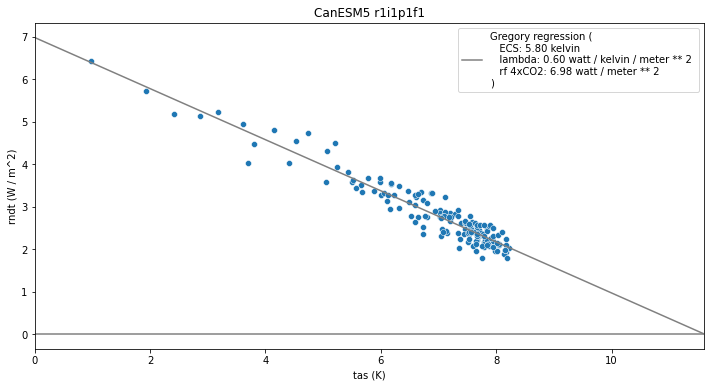

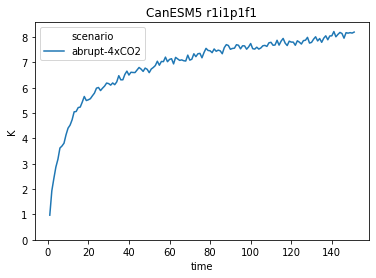

{'lambda': 0.6497898883264817 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.288803716040347 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.6444018580201734 <Unit('watt / meter ** 2')>,
 'ecs': 5.608585057250188 <Unit('kelvin')>}

[ 0.         11.21717011]


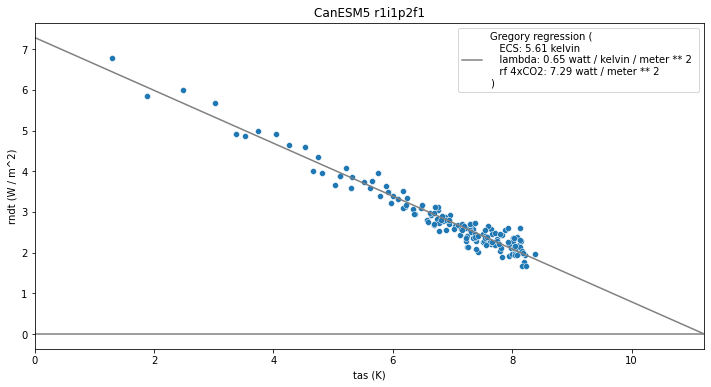

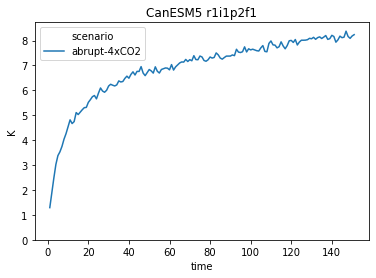

{'lambda': 0.627792635922301 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.661856915865821 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.3309284579329104 <Unit('watt / meter ** 2')>,
 'ecs': 5.305778161987176 <Unit('kelvin')>}

[ 0.         10.61155632]


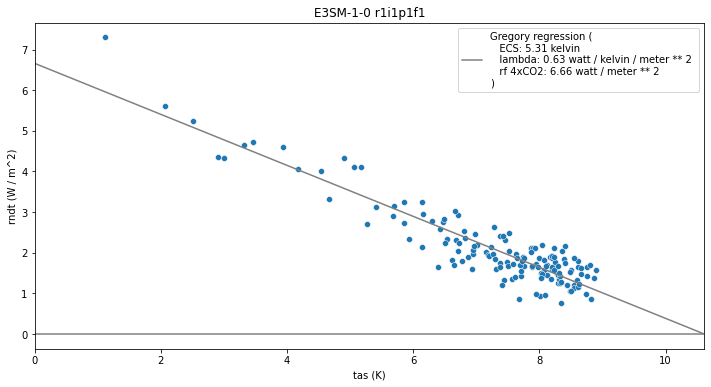

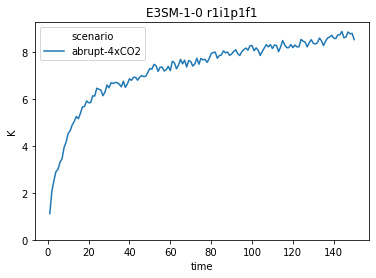

EC-Earth3-AerChem r1i1p1f1 is missing data for {'tas', 'rsdt', 'rlut'}


{'lambda': 0.7496800334962 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.550214007763478 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.275107003881739 <Unit('watt / meter ** 2')>,
 'ecs': 4.3686731105909065 <Unit('kelvin')>}

[0.         8.73734622]


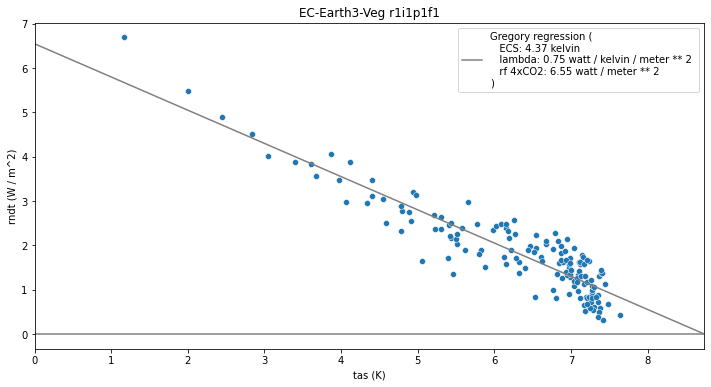

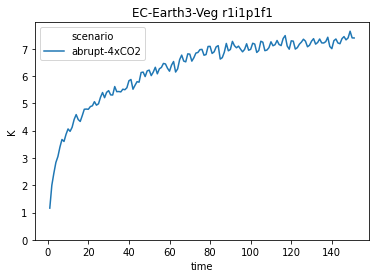

{'lambda': 1.2451148038598725 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.154679676303797 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.5773398381518984 <Unit('watt / meter ** 2')>,
 'ecs': 2.873100397699953 <Unit('kelvin')>}

[0.        5.7462008]


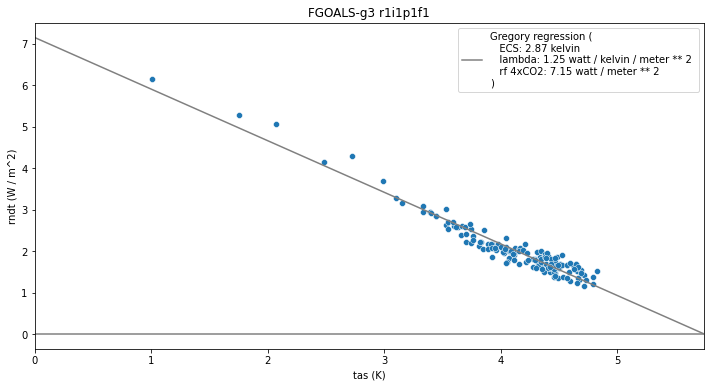

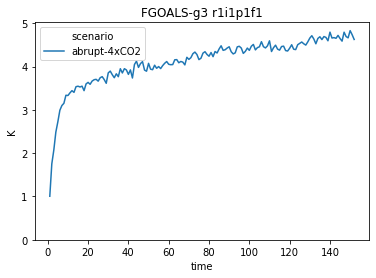

FIO-ESM-2-0 r1i1p1f1 is missing data for {'rsut', 'rsdt', 'rlut'}
FIO-ESM-2-0 r2i1p1f1 is missing data for {'rsut', 'rsdt', 'rlut'}
FIO-ESM-2-0 r3i1p1f1 is missing data for {'rsut', 'rsdt', 'rlut'}
GFDL-ESM4 r1i1p1f1 is missing data for {'rsut', 'rsdt', 'rlut'}


{'lambda': 1.2572292717680615 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.1126581054389435 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.5563290527194718 <Unit('watt / meter ** 2')>,
 'ecs': 2.8287036681210496 <Unit('kelvin')>}

[0.         5.65740734]


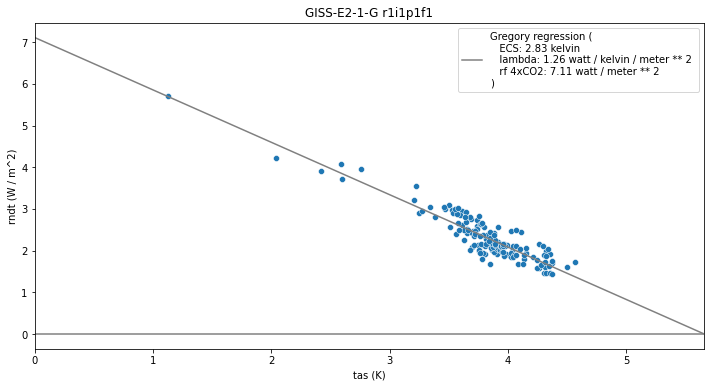

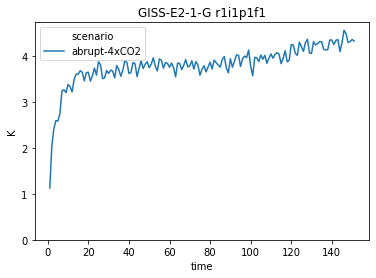

{'lambda': 1.711246297241206 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 10.599119564393806 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 5.299559782196903 <Unit('watt / meter ** 2')>,
 'ecs': 3.096900656989362 <Unit('kelvin')>}

[0.         6.19380131]


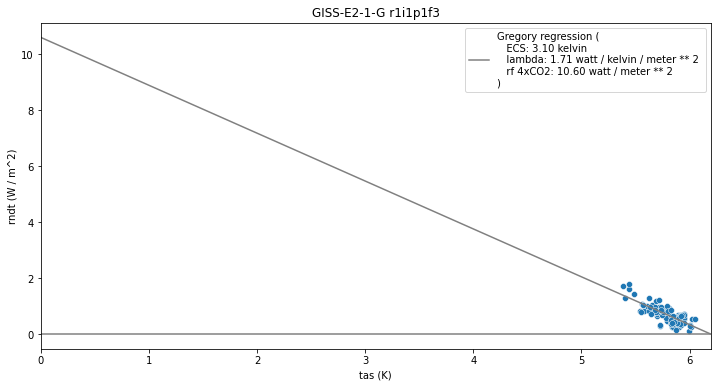

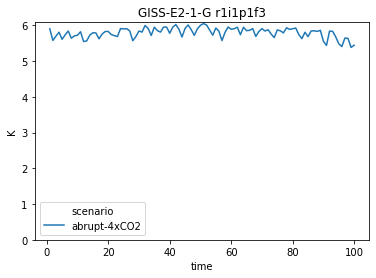

{'lambda': 1.0198765467730482 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.534347141502337 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.2671735707511687 <Unit('watt / meter ** 2')>,
 'ecs': 3.2034990716167617 <Unit('kelvin')>}

[0.         6.40699814]


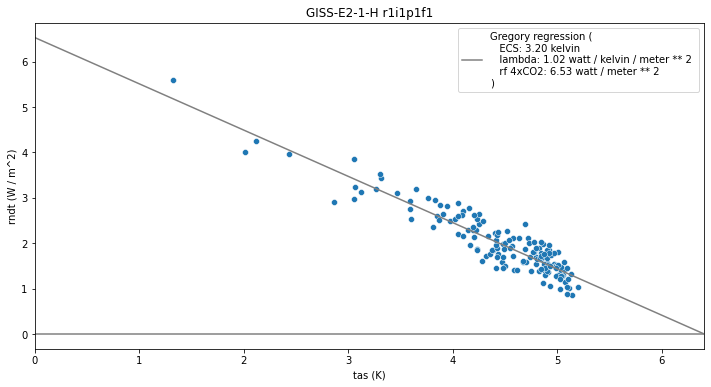

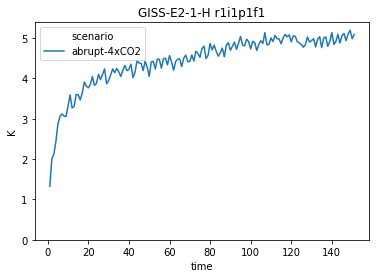

{'lambda': 1.6266085948307705 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.711481313060722 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.855740656530361 <Unit('watt / meter ** 2')>,
 'ecs': 2.3704169944654114 <Unit('kelvin')>}

[0.         4.74083399]


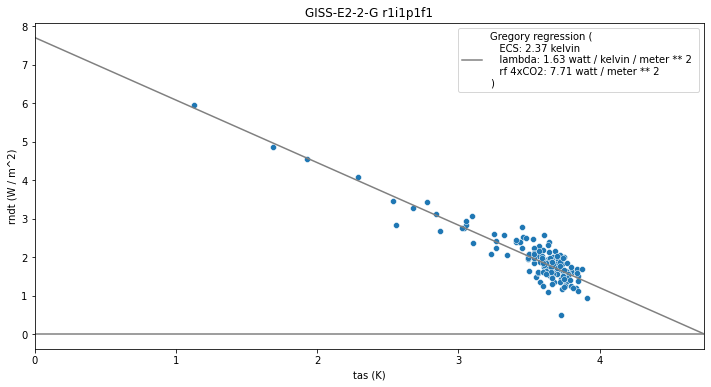

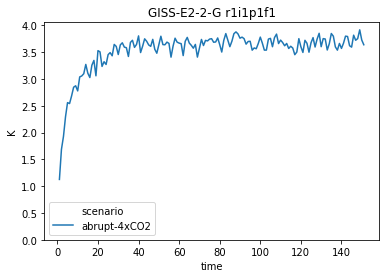

{'lambda': 0.6449306262991846 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.089789557056737 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.5448947785283687 <Unit('watt / meter ** 2')>,
 'ecs': 5.49655208478793 <Unit('kelvin')>}

[ 0.         10.99310417]


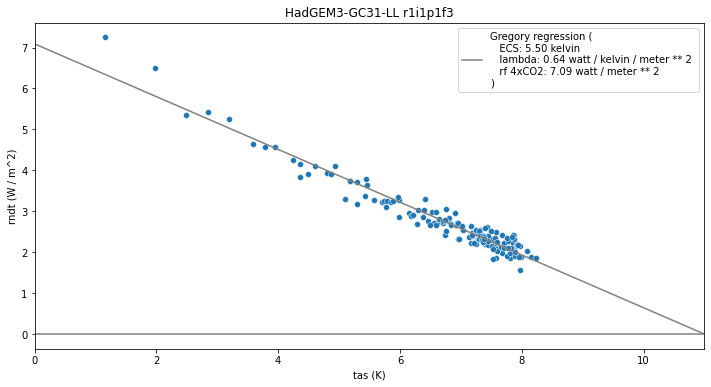

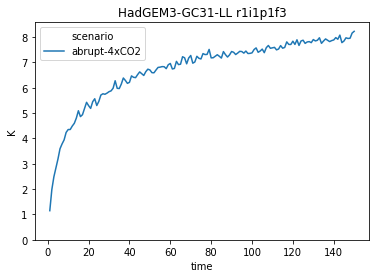

{'lambda': 0.6976465788328237 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.422808454295818 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.711404227147909 <Unit('watt / meter ** 2')>,
 'ecs': 5.319891675462898 <Unit('kelvin')>}

[ 0.         10.63978335]


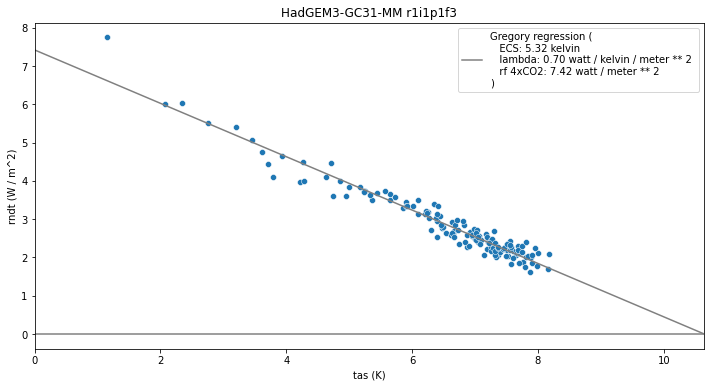

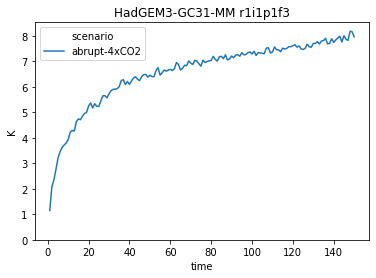

INM-CM4-8 r1i1p1f1 is missing data for {'rsut'}
INM-CM5-0 r1i1p1f1 is missing data for {'rsut', 'rlut'}


{'lambda': 0.8062389128823552 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.145265097637046 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.072632548818523 <Unit('watt / meter ** 2')>,
 'ecs': 3.8110695225980438 <Unit('kelvin')>}

[0.         7.62213905]


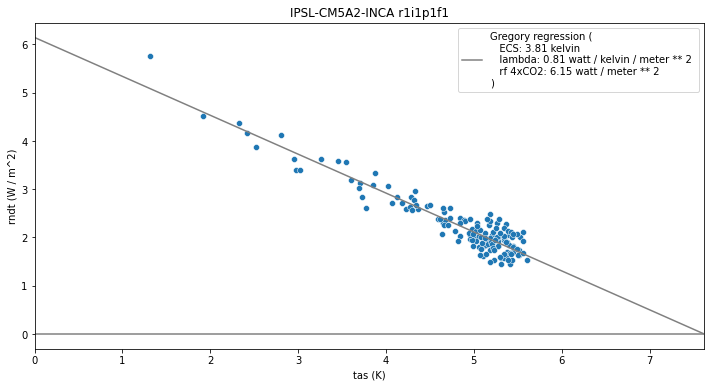

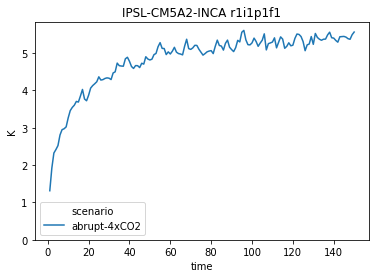

Insufficient data for IPSL-CM6A-LR r10i1p1f1
Insufficient data for IPSL-CM6A-LR r11i1p1f1


{'lambda': 0.5592443316800446 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 5.658794256643054 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 2.829397128321527 <Unit('watt / meter ** 2')>,
 'ecs': 5.059321960084317 <Unit('kelvin')>}

[ 0.         10.11864392]


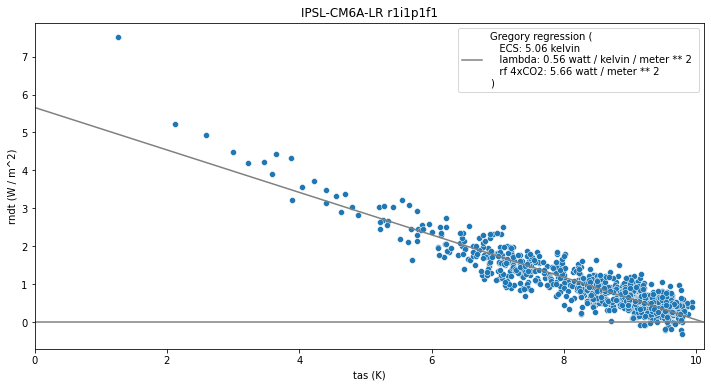

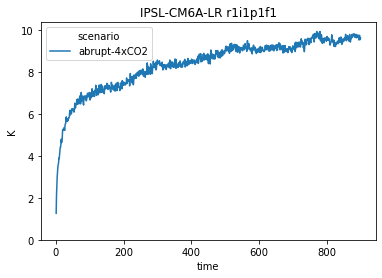

Insufficient data for IPSL-CM6A-LR r2i1p1f1
Insufficient data for IPSL-CM6A-LR r3i1p1f1
Insufficient data for IPSL-CM6A-LR r4i1p1f1


{'lambda': 1.522852502620816 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 8.131010785298391 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 4.065505392649196 <Unit('watt / meter ** 2')>,
 'ecs': 2.6696645838336255 <Unit('kelvin')>}

[0.         5.33932917]


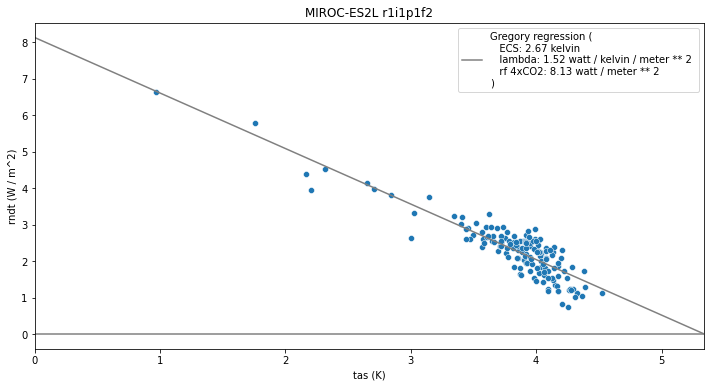

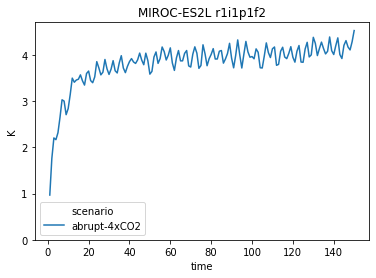

{'lambda': 1.359306952148805 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.181904254153229 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.5909521270766147 <Unit('watt / meter ** 2')>,
 'ecs': 2.6417521968823925 <Unit('kelvin')>}

[0.         5.28350439]


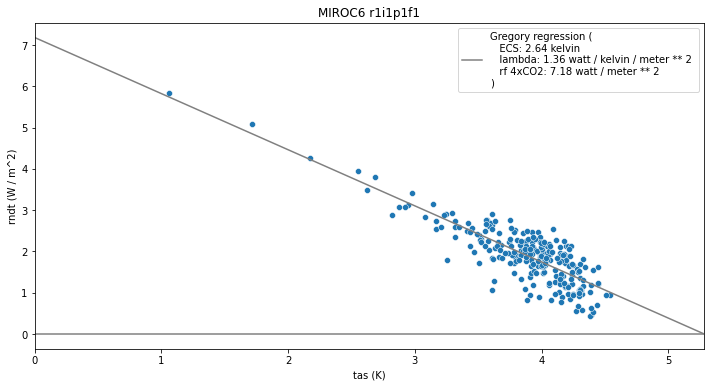

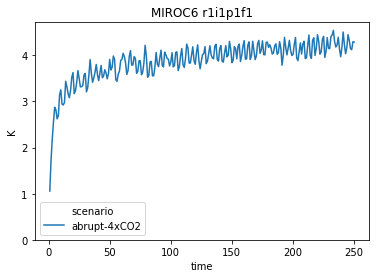

{'lambda': 1.4109137719739753 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 8.331409283903698 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 4.165704641951849 <Unit('watt / meter ** 2')>,
 'ecs': 2.952487051085845 <Unit('kelvin')>}

[0.        5.9049741]


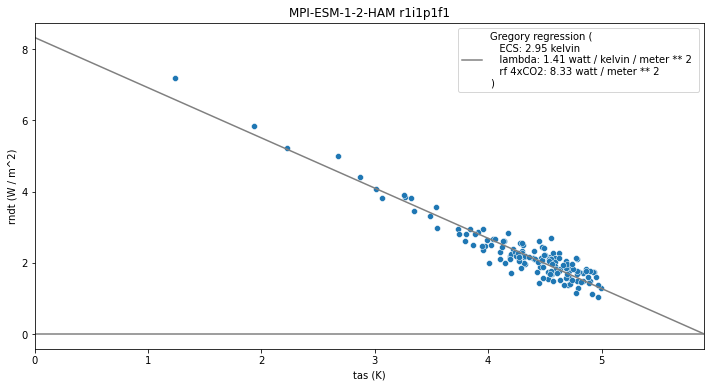

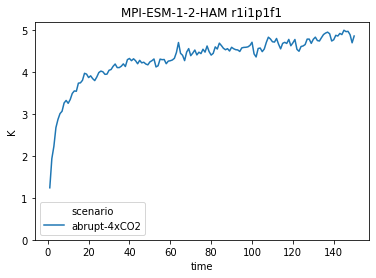

{'lambda': 1.201904279677288 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.198028513327883 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.5990142566639416 <Unit('watt / meter ** 2')>,
 'ecs': 2.99442669230721 <Unit('kelvin')>}

[0.         5.98885338]


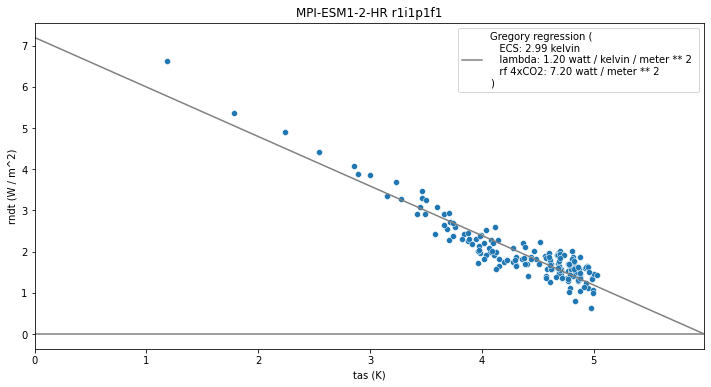

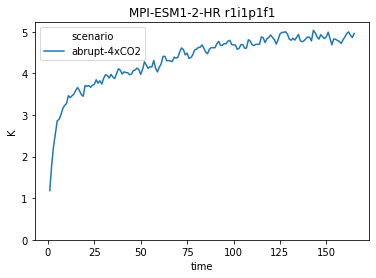

{'lambda': 1.5823735486694328 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 9.320767404909292 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 4.660383702454646 <Unit('watt / meter ** 2')>,
 'ecs': 2.945185545077781 <Unit('kelvin')>}

[0.         5.89037109]


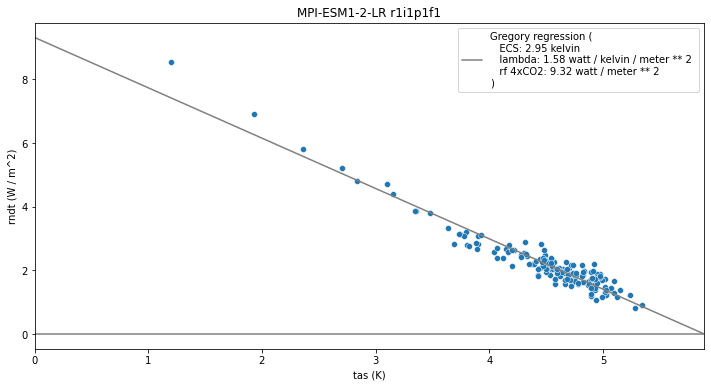

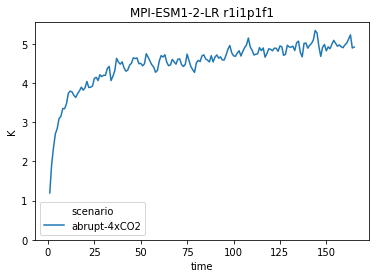

{'lambda': 0.7411006544947302 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 5.348164359127324 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 2.674082179563662 <Unit('watt / meter ** 2')>,
 'ecs': 3.608257749261881 <Unit('kelvin')>}

[0.        7.2165155]


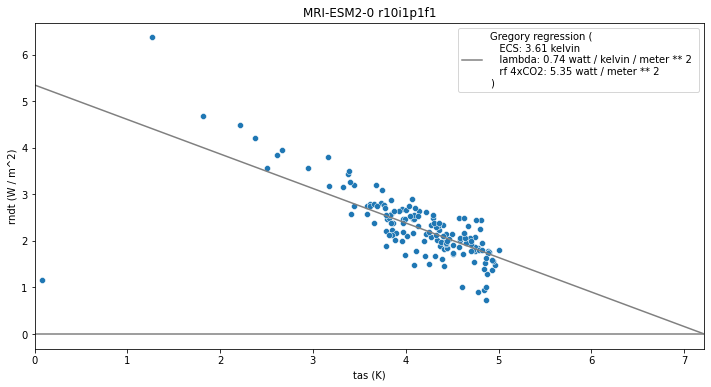

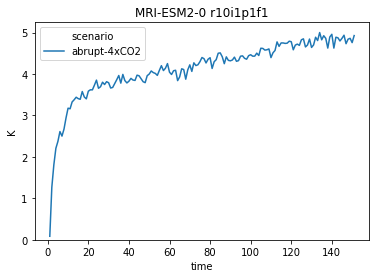

{'lambda': 1.0173606023263004 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.53104193670312 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.26552096835156 <Unit('watt / meter ** 2')>,
 'ecs': 3.2097969597845717 <Unit('kelvin')>}

[0.         6.41959392]


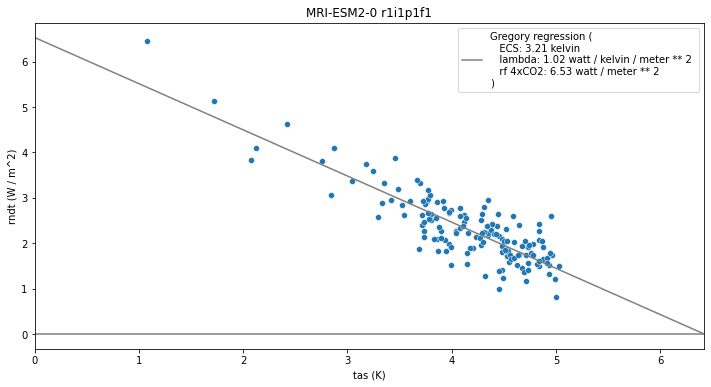

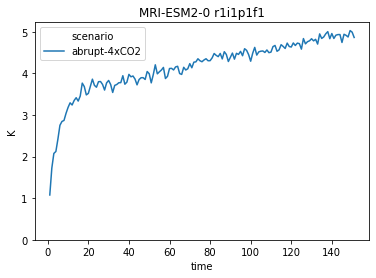

{'lambda': 0.9662000514267759 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 6.3133944155250274 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.1566972077625137 <Unit('watt / meter ** 2')>,
 'ecs': 3.267125894995614 <Unit('kelvin')>}

[0.         6.53425179]


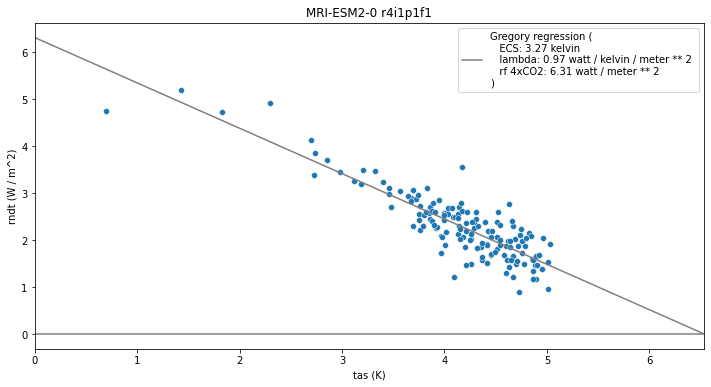

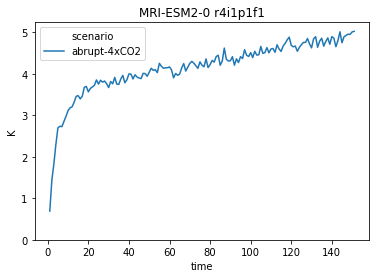

{'lambda': 1.1970114574122999 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.08410339546253 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.542051697731265 <Unit('watt / meter ** 2')>,
 'ecs': 2.959079193267268 <Unit('kelvin')>}

[0.         5.91815839]


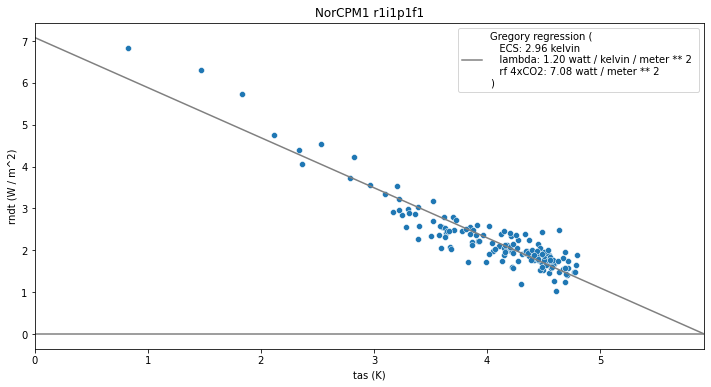

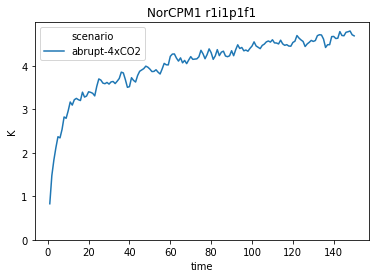

{'lambda': 0.2572489553352163 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 3.019208441719036 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 1.509604220859518 <Unit('watt / meter ** 2')>,
 'ecs': 5.868261812345869 <Unit('kelvin')>}

[ 0.         11.73652362]


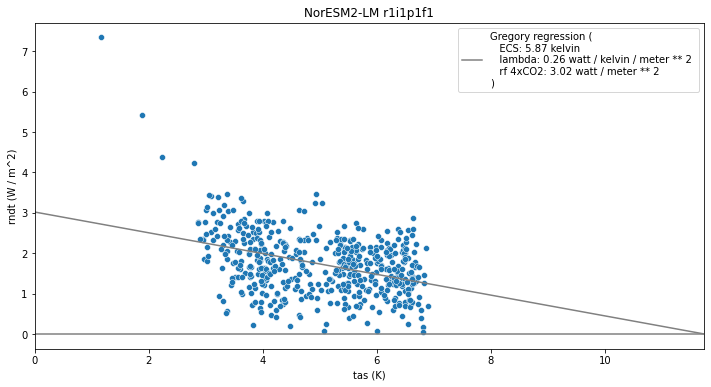

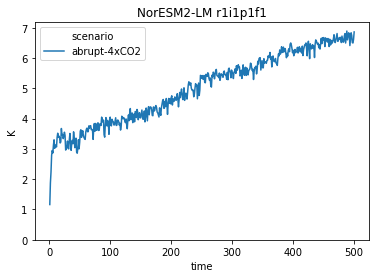

{'lambda': 1.6491737593824884 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 8.02146457594453 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 4.010732287972265 <Unit('watt / meter ** 2')>,
 'ecs': 2.4319646520898024 <Unit('kelvin')>}

[0.        4.8639293]


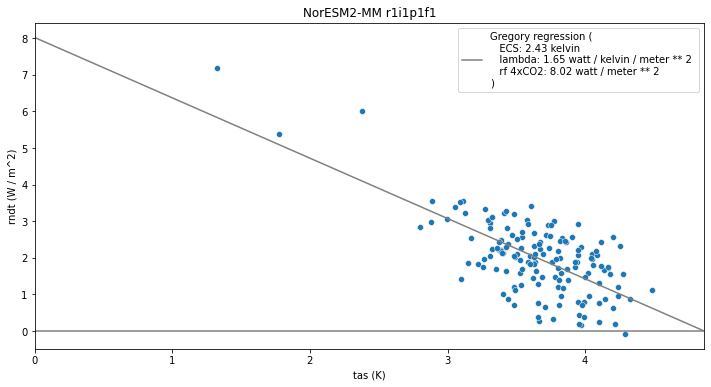

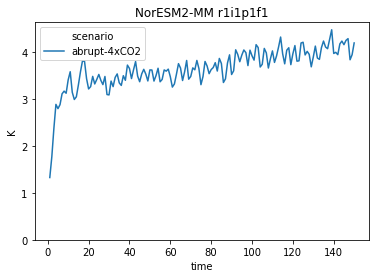

{'lambda': 1.0454142144084466 <Unit('watt / kelvin / meter ** 2')>,
 'rf_4xco2': 7.785441278598336 <Unit('watt / meter ** 2')>,
 'rf_2xco2': 3.892720639299168 <Unit('watt / meter ** 2')>,
 'ecs': 3.7236155637140302 <Unit('kelvin')>}

[0.         7.44723113]


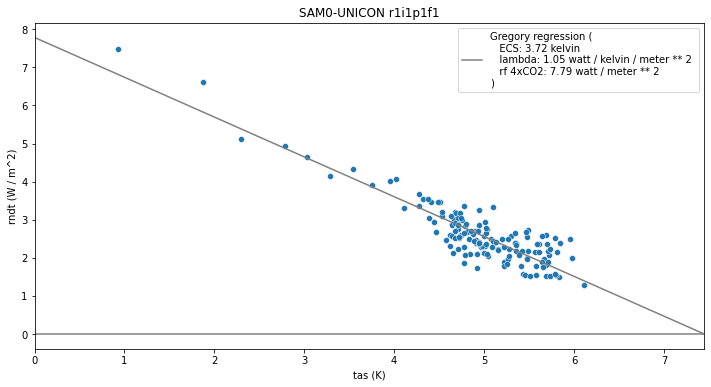

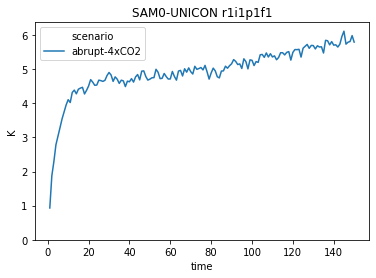

UKESM1-0-LL r1i1p1f2 is missing data for {'tas', 'rlut'}


,climate_model,member_id,rf4xco2,rf4xco2_unit,ecs,ecs_unit
0,ACCESS-CM2,r1i1p1f1,6.885,W / m^2,4.652,K
1,ACCESS-ESM1-5,r1i1p1f1,5.516,W / m^2,3.941,K
2,AWI-CM-1-1-MR,r1i1p1f1,7.261,W / m^2,3.162,K
3,BCC-CSM2-MR,r1i1p1f1,6.674,W / m^2,2.947,K
4,BCC-ESM1,r1i1p1f1,5.728,W / m^2,3.328,K
5,CAMS-CSM1-0,r1i1p1f1,8.341,W / m^2,2.291,K
6,CAMS-CSM1-0,r2i1p1f1,8.393,W / m^2,2.291,K
7,CESM2-FV2,r1i1p1f1,5.721,W / m^2,5.156,K
8,CESM2-WACCM,r1i1p1f1,6.605,W / m^2,4.683,K
9,CESM2-WACCM-FV2,r1i1p1f1,5.843,W / m^2,4.783,K


<scmdata.ScmRun (timeseries: 40, timepoints: 1000)>
Time:
	Start: 0001-07-01T00:00:00
	End: 1000-07-01T00:00:00
Meta:
	   activity_id    climate_model grid  member_id mip_era        model region  \
	0         CMIP       ACCESS-CM2   gn   r1i1p1f1   CMIP6  unspecified  World   
	1         CMIP    ACCESS-ESM1-5   gn   r1i1p1f1   CMIP6  unspecified  World   
	2         CMIP    AWI-CM-1-1-MR   gn   r1i1p1f1   CMIP6  unspecified  World   
	3         CMIP      BCC-CSM2-MR   gn   r1i1p1f1   CMIP6  unspecified  World   
	4         CMIP         BCC-ESM1   gn   r1i1p1f1   CMIP6  unspecified  World   
	5         CMIP      CAMS-CSM1-0   gn   r1i1p1f1   CMIP6  unspecified  World   
	6         CMIP      CAMS-CSM1-0   gn   r2i1p1f1   CMIP6  unspecified  World   
	7         CMIP        CESM2-FV2   gn   r1i1p1f1   CMIP6  unspecified  World   
	8         CMIP      CESM2-WACCM   gn   r1i1p1f1   CMIP6  unspecified  World   
	9         CMIP  CESM2-WACCM-FV2   gn   r1i1p1f1   CMIP6  unspecified  World   
	1

<IPython.core.display.Javascript object>

In [11]:
tas_unit = "K"
flux_unit = "W / m^2"

rf4xco2s = []
tas_timeseries = []
for i, cm_em_scmrun in enumerate(
    tqdman.tqdm(all_dat.time_mean("AC").groupby(["climate_model", "member_id"]))
):
    climate_model = cm_em_scmrun.get_unique_meta("climate_model", True)
    member_id = cm_em_scmrun.get_unique_meta("member_id", True)

    missing_vars = {"rlut", "rsdt", "rsut", "tas"} - set(
        cm_em_scmrun.get_unique_meta("variable")
    )
    if missing_vars:
        print(f"{climate_model} {member_id} is missing data for {missing_vars}")
        continue

    gregory_plot_df = get_gregory_plot_df(
        cm_em_scmrun, tas_unit=tas_unit, flux_unit=flux_unit
    ).dropna()
    if gregory_plot_df.shape[0] < 100:
        print(f"Insufficient data for {climate_model} {member_id}")
        continue

    gregory_regression_values = get_gregory_regression_values(
        gregory_plot_df, tas_unit, flux_unit
    )
    display(gregory_regression_values)
    rf4xco2s.append(
        {
            "climate_model": climate_model,
            "member_id": member_id,
            "rf4xco2": np.round(
                gregory_regression_values["rf_4xco2"].to(flux_unit).magnitude, 3
            ),
            "rf4xco2_unit": flux_unit,
            "ecs": np.round(gregory_regression_values["ecs"].to(tas_unit).magnitude, 3),
            "ecs_unit": tas_unit,
        }
    )

    ax = plt.figure(figsize=(12, 6)).add_subplot(111)
    make_gregory_plot(
        gregory_regression_values, gregory_plot_df, tas_unit, flux_unit, ax, style=None
    )

    plt.show()

    tas_ts = cm_em_scmrun.filter(variable="tas")
    ax = tas_ts.lineplot(time_axis="year")
    ax.set_title(f"{climate_model} {member_id}")
    ax.set_ylim(ymin=0)
    plt.show()

    tas_timeseries.append(tas_ts)
#     break

rf4xco2s = pd.DataFrame(rf4xco2s)
display(rf4xco2s)
tas_timeseries = scmdata.run_append(tas_timeseries)
tas_timeseries

In [12]:
cm_u = rf4xco2s["climate_model"].unique()
display(len(cm_u))
sorted(cm_u)

35

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'FGOALS-g3',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'GISS-E2-2-G',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorCPM1',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON']

<IPython.core.display.Javascript object>

In [13]:
tas_timeseries.to_csv("{}-irf-calibration-data-tas-timeseries.csv".format(ID))
rf4xco2s.to_csv("{}-irf-calibration-data-rf4xco2.csv".format(ID))

<IPython.core.display.Javascript object>